# Bayesian Logistic Regression using SVGD

This notebook demonstrates how to perform Bayesian inference on a logistic regression model using **Stein Variational Gradient Descent (SVGD)**. We apply it to the breast cancer classification dataset from scikit-learn.

In [2]:
!pip install jax jaxlib matplotlib seaborn scikit-learn arviz pymc pytensor > /dev/null

In [3]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jax import grad, vmap
import jax
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import arviz as az
import pymc as pm
import pytensor.tensor as pt

np.random.seed(42)

## SVGD Utilities (JAX)

In [4]:
def rbf_kernel_jax(x):
    n, d = x.shape
    pairwise_dists = jnp.sum((x[:, None] - x[None, :])**2, axis=-1)
    h = jnp.median(pairwise_dists) / jnp.log(n + 1.0)
    K = jnp.exp(-pairwise_dists / h)
    return K, h

def svgd_update_jax(particles, log_prob_fn, steps=500, lr=1e-3):
    history = [particles]
    n_particles = particles.shape[0]
    grad_logp = vmap(grad(log_prob_fn))

    for i in range(steps):
        Kxy, h = rbf_kernel_jax(particles)
        grad_log_p = grad_logp(particles)

        def phi(i):
            diff = particles[i] - particles
            kernel_grad = jnp.sum(Kxy[i][:, None] * (-2 * diff / h), axis=0)
            return (Kxy[i] @ grad_log_p + kernel_grad) / n_particles

        phi_v = vmap(phi)(jnp.arange(n_particles))
        particles += lr * phi_v
        if i % 100 == 0:
            history.append(particles)
    return particles, history

## Load and Prepare Dataset

In [5]:
data = load_breast_cancer()
X = StandardScaler().fit_transform(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train)

## Define Bayesian Logistic Posterior

In [6]:
def log_posterior_jax(w):
    logits = X_train_jax @ w
    log_lik = jnp.sum(y_train_jax * logits - jnp.logaddexp(0, logits))
    log_prior = -0.5 * jnp.sum(w**2)
    return log_lik + log_prior

## Run SVGD with 500 Iterations

In [7]:
init_weights = jnp.array(np.random.randn(100, X_train.shape[1]))
w_final, history = svgd_update_jax(init_weights, log_posterior_jax, steps=500, lr=1e-3)

## Visualize Particle Distribution at Different Iterations

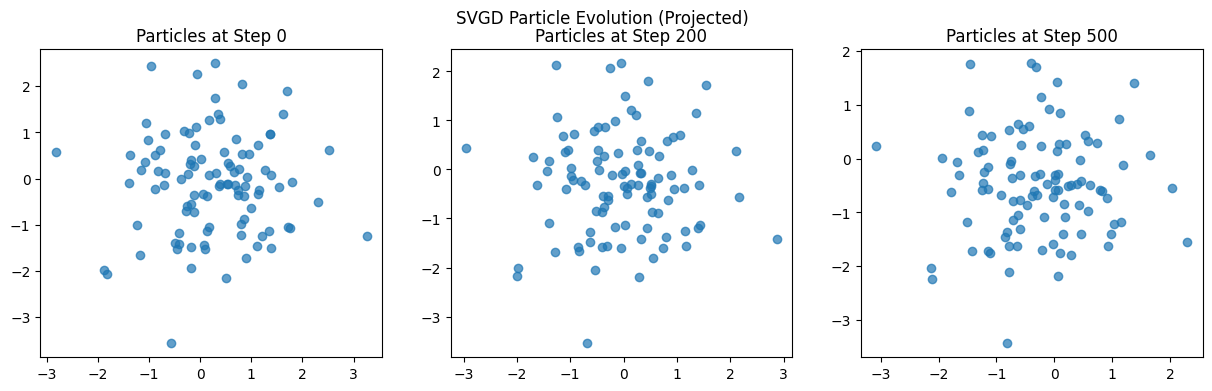

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    idx = i * (len(history) - 1) // 2
    proj = np.array(history[idx])[:, :2]  # first 2 dims
    ax.scatter(proj[:, 0], proj[:, 1], alpha=0.7)
    ax.set_title(f'Particles at Step {idx * 100}')
plt.suptitle("SVGD Particle Evolution (Projected)")
plt.show()

## Predictive Posterior Distribution

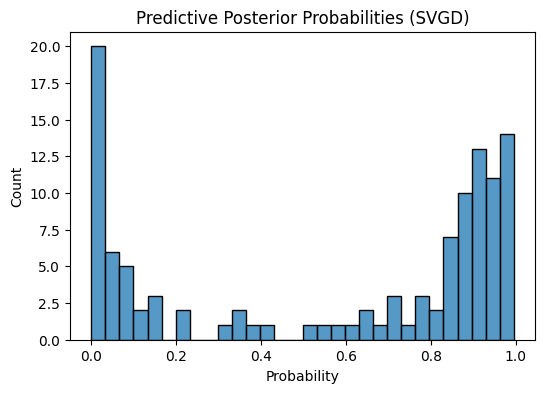

In [9]:
X_test_jax = jnp.array(X_test)
logits = X_test_jax @ w_final.T
probs = jax.nn.sigmoid(logits)
mean_probs = np.array(probs.mean(axis=1))

plt.figure(figsize=(6, 4))
sns.histplot(mean_probs, bins=30)
plt.title("Predictive Posterior Probabilities (SVGD)")
plt.xlabel("Probability")
plt.show()

### Commentary
- Particles evolve from random weights to form a posterior over weights.
- Final histogram shows predicted probabilities for test data, capturing uncertainty.
- SVGD approximates Bayesian inference efficiently and provides uncertainty-aware predictions.
- While not as exact as HMC, it scales better and is easier to implement with autodiff tools like JAX.